In [660]:
%matplotlib inline

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from ipytest import run_pytest, clean_tests, magics
import pytest

sns.set_context(rc = {'patch.linewidth': 2.0})
sns.set_style("white")
sns.set_palette(sns.color_palette("dark"))
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('seaborn-white')

data_dir = '../data/'
_filename_ = 'Testing.ipynb'

In [3]:
df_switrs = pd.DataFrame.from_csv(data_dir + 'df_switrs.csv')
df_switrs.head()

,Segment_ID,State_Route,Caltrans_District,Caltrans_County,Postmile,Side_Of_Highway,Forward,Latitude,Longitude,GPS_Valid,Collision_Year,Collision_Month,Collision_Day,Collision_DayOfWeek,Collision_Hour,Collision_Minute,Collision_Hours,Collision_Minutes
4577214,1954,60.0,8.0,RIV,2.87,E,True,34.01847,-117.50958,True,2010,1,19,1,1,20,1.333333,80.0
4577218,946,15.0,8.0,SBD,7.68,S,False,NaN,NaN,False,2010,2,6,5,4,50,4.833333,290.0
4577222,-1,58.0,8.0,SBD,31.09,E,True,NaN,NaN,False,2010,1,17,6,18,35,18.583333,1115.0
4577223,1521,40.0,8.0,SBD,54.30,W,False,34.72775,-116.08762,True,2010,1,13,2,10,25,10.416667,625.0
4577224,2299,79.0,8.0,RIV,35.37,N,True,NaN,NaN,False,2010,1,23,5,22,57,22.950000,1377.0


In [584]:
# Draw each collision using the Latitude and Longitude coordinates

def draw_collision_map(df, colors = None):
    fig = plt.figure(figsize=(12, 12))
    plt.ylim(31, 43)
    plt.xlim(-125, -113)
    plt.scatter(df.Longitude, df.Latitude, s=0.8, c=colors)
    plt.title("Traffic Accidents Across California", fontsize=24)
    plt.xlabel("Longitude", fontsize=18)
    plt.xticks(fontsize=16)
    plt.ylabel("Latitude", fontsize=18)
    plt.yticks(fontsize=16)
    
    return fig

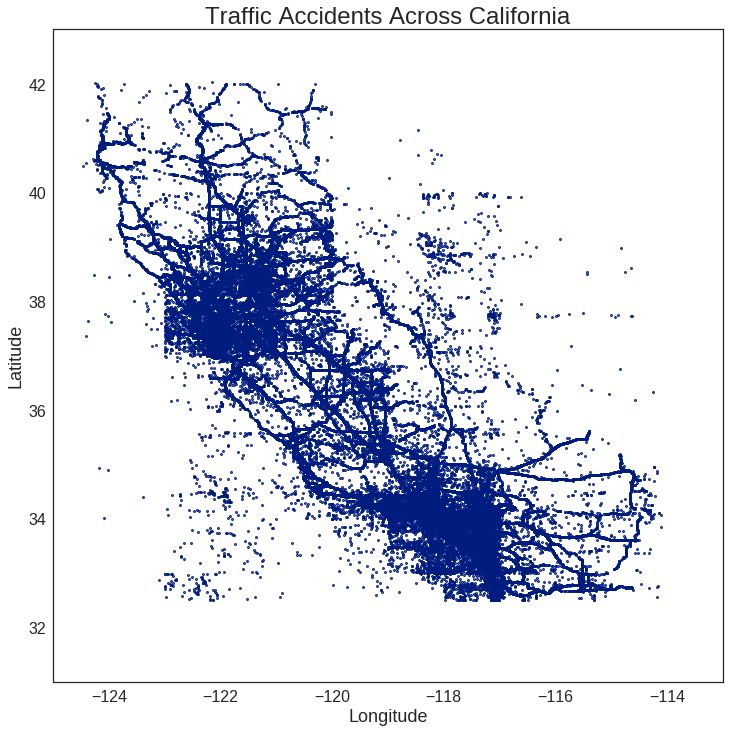

In [585]:
draw_collision_map(df_switrs);

In [387]:
# Define test coordinates to check whether in bounds

c1 = (34, -122)
c2 = (40, -121)
c3 = (34, -118)
c4 = (40, -117)

_coords = [c1, c2, c3, c4]
_results = [False, True, True, False]

In [388]:
# Define coordinates for line segment ends of test bounds

b1 = (42, -125)
b2 = (33, -119)
b3 = (33, -114)
b4 = (42, -120)

_bounds = [b1, b2, b3, b4]
_line_checks = [True, True, False, False]

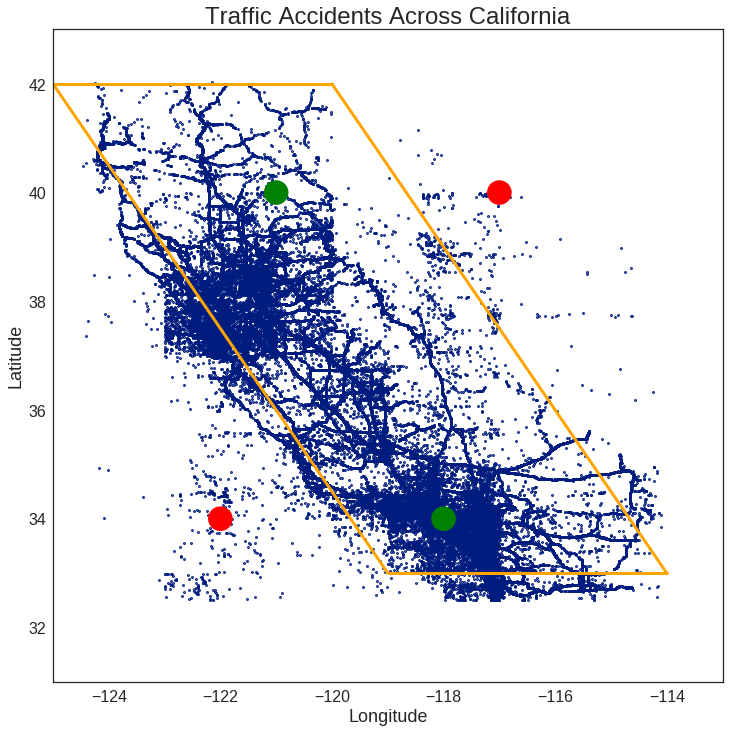

In [674]:
def draw_collision_map_with_features(df, coords, results, bounds, colors = None):
    # Draw initial map, with subplot to draw lines
    fig = draw_collision_map(df, colors)  
    axes = fig.add_subplot(111)  
    
    # Translate GPS coordinates into (x, y) format
    points = zip(*[(lng, lat) for (lat, lng) in coords])
    
    # Assign colors based on whether or not in bounds
    colors = ['g' if result else 'r' for result in results]
    
    # Add test points, color-coded by whether supposed to be in bounds (T: 'g', F: 'r')
    plt.scatter(*points, c=colors, s=512)    
    
    # Add individual test line segments
    for i in xrange(len(bounds)):
        l1 = bounds[i]
        l2 = bounds[(i + 1) % len(bounds)]            
        
        line = plt.Line2D([l1[1], l2[1]], [l1[0], l2[0]], \
                          linewidth=3, linestyle='solid', color='orange')
        axes.add_line(line)
        
    return fig, axes

draw_collision_map_with_features(df_switrs, _coords, _results, _bounds);

In [651]:
def get_line_eq(p1, p2):    
    """ Determines the slope and intercept of a line formed by two points.
    
    Input: 
        p1 (tuple: (float, float)) - 1st point in the form (x, y) 
        p2 (tuple: (float, float)) - 2nd point in the form (x, y) 
        
    Output:
        m (float) - slope of line
        b (float) - intercept of line
    """
    
    # List of potential error messages
    err_input_syntax = "Error: each point must be a tuple of floats in the form (x, y)."
    err_identical_points = "Error: identical points entered for p1 and p2."
    err_infinite_slope = "Error: slope is infinite, and has no valid intercept."    
    
    
    # Check validity of input parameters 
    try:
        x1, y1 = [float(p) for p in p1]
        x2, y2 = [float(p) for p in p2]
    except (TypeError, ValueError) as Error:
        raise Error(err_input_syntax)
        
    # Check for identical points (undefined slope and intercept)
    if (x1 == x2) and (y1 == y2):
        raise ValueError(err_identical_points)
        
    # Check for vertical line (infinite slope and no intercept)
    if x1 == x2:
        raise ValueError(err_infinite_slope)
        
    # Otherwise, return standard calculation from line formula
    m = (y1 - y2) / (x1 - x2) # Slope
    b = y1 - m * x1           # Intercept
    
    return m, b

In [661]:
# 'get_line_eq' Unit Testing

clean_tests()

_p1 = (1, 1)
_p2 = (2, 2)

invalid_vals = [
    None, 
    (),
    (1), 
    ((1, 2), None), 
    ((1, 2), 3), 
    ('test', 1),
    (1.5, 1.5, 1.5),
    ((1, 2, 3), (4, 5, 6), (7, 8, 9)),
]

## Error-based Tests

@pytest.mark.parametrize("p1", invalid_vals + [_p1])
@pytest.mark.parametrize("p2", invalid_vals + [_p2])
def test_input_errors(p1, p2):
    # Ignore base case
    if p1 == _p1 and p2 == _p2:
        return
    
    with pytest.raises((TypeError, ValueError)):
        get_line_eq(p1, p2)             

def test_identical_points():
    with pytest.raises(ValueError):
        get_line_eq(_p1, _p1)            
            
def test_infinite_slope():
    with pytest.raises(ValueError):
        get_line_eq((_p1[0], _p1[1]), (_p1[0], _p2[1]))

        
## Value-based Tests

@pytest.mark.parametrize("p1, p2, m, b", [  
    (( 2.0,  2.0), ( 3.0,  3.0),  1.00,  0.00), # Positive Slope 
    (( 0.5,  2.0), ( 3.5,  5.0),  1.00,  1.50), # Positive Intercept 
    ((-2.0,  2.0), ( 3.0, -3.0), -1.00,  0.00), # Negative Slope 
    (( 6.5,  4.5), (-3.5, -6.5),  1.10, -2.65), # Negative Intercept    
    (( 3.0,  5.0), ( 7.0,  5.0),  0.00,  5.00), # Zero Slope
])
def test_slope_values(p1, p2, m, b):
    (m_check, b_check) = get_line_eq(p1, p2)
    
    # Account for floating point precision when running tests
    assert np.isclose(m, m_check) and np.isclose(b, b_check)    

def test_mirrored_points():
    m1, b1 = get_line_eq(_p1, _p2)
    m2, b2 = get_line_eq(_p2, _p1)
    
    # Account for floating point precision when running tests
    assert np.isclose(m1, m2) and np.isclose(b1, b2)
    
run_pytest(filename=_filename_);

============================= test session starts ==============================
platform linux2 -- Python 2.7.13, pytest-3.0.5, py-1.4.32, pluggy-0.4.0
rootdir: /home/julin/Documents/Projects/Collision-Analysis/notebooks, inifile: 
collected 89 items

Testing.py .........................................................................................

========================== 89 passed in 0.28 seconds ===========================


In [636]:
def is_above_line(x, y, m, b, inclusive = True):  
    """ Checks whether an (x, y) coordinate is above the line defined by y = mx + b.
    
    Input:
        x (float) - x-coordinate of point to check
        y (float) - y-coordinate of point to check
        m (float) - slope of line to compare
        b (float) - intercept of line to compare
        inclusive (bool) [optional] - whether equality counts as above
        
    Output:
        above (bool): true if (x, y) coordinate is above line defined by y = mx + b
    """
    
    # List of potential error messages
    err_input = "Error: parameters must be finite float values."
    
    # Check validity of input parameters
    try:
        for i in [x, y, m, b]:      
            # Check for castable values
            i = float(i)
            
            # Check for infinite values
            if np.isinf(i):
                if i == m:
                    if inclusive:
                        return 
                else:
                    raise ValueError(err_input)                    
    except (TypeError, ValueError) as Error:
        raise Error(err_input)
        
    # Return comparison to line height based on inclusive
    if inclusive:
        return y >= m * x + b
    else:
        return y >  m * x + b

In [664]:
# 'is_above_line' Unit Testing

clean_tests()

## Error-based Tests

@pytest.mark.parametrize("x, y, m, b", [
    (3, 3, None, 1),    # Null arguments
    (3, 3, (2, 2), 1),  # Non-castable arguments
    (np.inf, 3, 1, 1)  # Infinite arguments
])
def test_input_errors(x, y, m, b):
    with pytest.raises((TypeError, ValueError)):
        is_above_line(x, y, m, b)


## Value-based Tests

@pytest.mark.parametrize("x, y, m, b, inclusive, above", [  
    ( 2.0,  2.0,  1.0,  0.0, True , True ), # Above Line 
    ( 2.0, -2.0,  1.0,  0.0, True , False), # Below Line 
    ( 2.0, -1.0, -2.0,  0.0, True , True ), # Above Line (negative slope)
    ( 2.0,  2.0,  1.0, -2.0, True , True ), # Above Line (with intercept)
    ( 1.0,  1.0,  1.0,  0.0, True , True ), # On Line (inclusive)
    ( 1.0,  1.0,  1.0,  0.0, False, False), # On Line (exclusive)
])
def test_above_values(x, y, m, b, inclusive, above):
    assert is_above_line(x, y, m, b, inclusive=inclusive) == above
    

run_pytest(filename=_filename_);

============================= test session starts ==============================
platform linux2 -- Python 2.7.13, pytest-3.0.5, py-1.4.32, pluggy-0.4.0
rootdir: /home/julin/Documents/Projects/Collision-Analysis/notebooks, inifile: 
collected 9 items

Testing.py .........

=========================== 9 passed in 0.06 seconds ===========================


In [557]:
def is_valid_gps(coords):
    """ Checks whether the given GPS coordinates are properly formatted.
    
    Input:
        coords (tuple: (float, float)) - coordinates to check in form (lat, lng)
        
    Output:
        valid (bool) - whether coords represent valid latitude and longitude values
    """
    
    # Check if there are two values each castable into floats
    try:
        if len(coords) != 2:
            return False
        
        lat, lng = [float(c) for c in coords]
    except:
        return False
    
    # If indeed floats, make sure they're in the range of latitude and longitude
    return (-90 <= lat and lat <= 90) and (-180 <= lng and lng <= 180)

In [665]:
# 'is_valid_gps' Unit Testing

clean_tests()

test_vals = [
    None,
    (1),
    (1, None),
    (1, 'test'),
    (10000, 1),
    (1, 2, 3)
]

## Value-based Tests
        
@pytest.mark.parametrize("coords", test_vals)
def test_input_errors(coords):
    assert is_valid_gps(coords) == False
    
@pytest.mark.parametrize("coords", _coords)
def test_valid_points(coords):
    assert is_valid_gps(coords) == True
        
        
run_pytest(filename=_filename_);

============================= test session starts ==============================
platform linux2 -- Python 2.7.13, pytest-3.0.5, py-1.4.32, pluggy-0.4.0
rootdir: /home/julin/Documents/Projects/Collision-Analysis/notebooks, inifile: 
collected 10 items

Testing.py ..........

========================== 10 passed in 0.05 seconds ===========================


In [559]:
def is_in_bounds(coords, bounds, line_checks):  
    """ Checks whether the given coordinates lie within a specified closed boundary.
    
    Input:
        coords (tuple: (float, float)) - coordinates to check in form (lat, lng)
        bounds (list: tuple: (float, float)) - coordinates defining line segment 
            end points in form (lat, lng)
        line_checks (list: bool) - whether point should be above each line segment to be 
            considered within the boundary
            
    Output:
        in_bounds (bool) - whether coords lies in area defined by bounds
    """    
    
    # List of potential error messages
    err_coords = "Error: 'coords' must be tuple of floats in the form (lat, lng)"
    err_bounds = "Error: 'bounds' must be a list of tuples of floats in the form (lat, lng)"
    err_line_checks = "Error: 'line_checks' must be a list of bools"
    err_line_lengths = "Error: 'bounds' must be the same length as 'line_checks'"
        
    # Check validity of input GPS coordinates
    if not is_valid_gps(coords):
        raise TypeError(err_coords)
        
    # Check validity of input boundary coordinates
    if len(bounds) == 0:
        raise TypeError(err_bounds)
        
    for bound in bounds:
        if not is_valid_gps(bound):
            raise TypeError(err_bounds)
        
    # Check validity of input line segment checks
    if len(line_checks) == 0:
        raise TypeError(err_line_checks)

    for l in line_checks:
        if not isinstance(l, int):
            raise TypeError(err_line_checks)
        
    # Make sure the number of entries in `line_checks` and `bounds` are the same
    assert (len(bounds) ==  len(line_checks))
        
    bounds = np.array(bounds)   
    N_bounds = len(bounds)
    
    # Check to make sure point is within longitude range of boundary
    lat, lng = coords
    
    min_lng = np.min(bounds[:, 1])
    max_lng = np.max(bounds[:, 1])
    
    if min_lng > lng or max_lng < lng:
        return False
        
    # Check each line segment to see if coords are correctly above / below
    for i in xrange(N_bounds):
        # Convert looped variables to more readible names
        lat1, lng1 = gps1 = bounds[i]
        lat2, lng2 = gps2 = bounds[(i + 1) % N_bounds] # Loop around if on last element
        above = line_checks[i]
        
        # If the coordinate is not along this line segment, there's nothing to check 
        if lng < min(lng1, lng2) or lng > max(lng1, lng2):
            continue
        
        # Otherwise, make sure the point is correctly above / below this line segment
        if is_above_line(lng, lat, *get_slope_eq(gps1, gps2)) != above:
            return False
    
    return True 

In [666]:
# 'is_in_bounds' Unit Testing

clean_tests()

## Error-based Tests
        
@pytest.mark.parametrize("coords", error_vals + [_coords[0]])
@pytest.mark.parametrize("bounds", error_vals + [_bounds])
@pytest.mark.parametrize("line_checks", error_vals + [_line_checks])
def test_input_errors(coords, bounds, line_checks):
    # Ignore base case
    if coords == _coords[0] and bounds == _bounds and line_checks == _line_checks:
        return 
    
    with pytest.raises(TypeError):
        is_in_bounds(coords, bounds, line_checks)
        
def test_matching_line_segment_lengths():
    with pytest.raises(AssertionError):
        is_in_bounds(_coords[0], _bounds, _line_checks[:-1])

        
## Value-based Tests

@pytest.mark.parametrize("coords, bounds, line_checks, in_bounds", [
    (_coords[0], _bounds, _line_checks, _results[0]),
    (_coords[1], _bounds, _line_checks, _results[1]),
    (_coords[2], _bounds, _line_checks, _results[2]),
    (_coords[3], _bounds, _line_checks, _results[3]),
])
def test_points(coords, bounds, line_checks, in_bounds):
    assert is_in_bounds(coords, bounds, line_checks) == in_bounds
        
def test_out_of_bounds():
    assert is_in_bounds((38, 100), _bounds, _line_checks) == False
        
run_pytest(filename=_filename_);

============================= test session starts ==============================
platform linux2 -- Python 2.7.13, pytest-3.0.5, py-1.4.32, pluggy-0.4.0
rootdir: /home/julin/Documents/Projects/Collision-Analysis/notebooks, inifile: 
collected 735 items

Testing.py ...............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

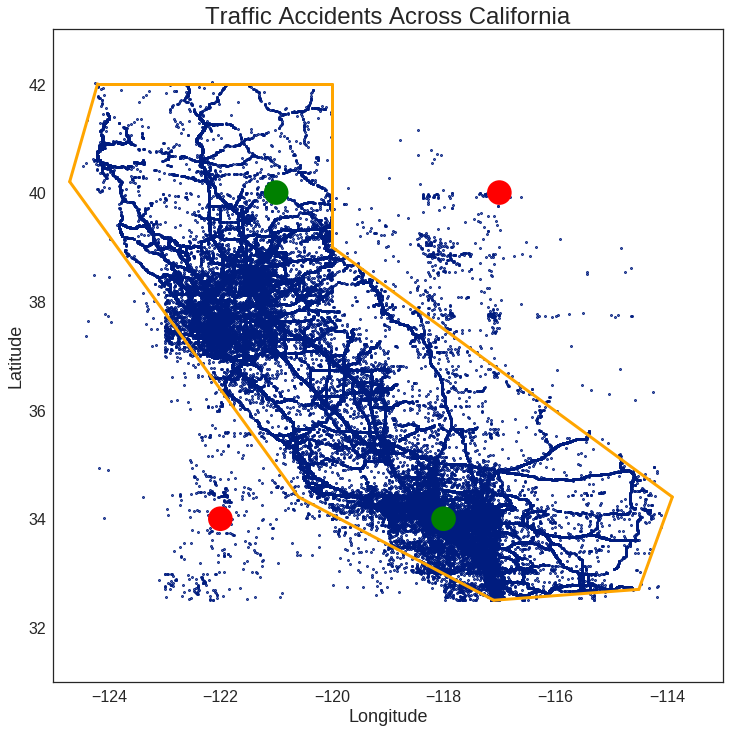

In [675]:
# Polygon Points
bp1 = (40.2, -124.7)
bp2 = (34.4, -120.6)
bp3 = (32.5, -117.1)
bp4 = (32.7, -114.5)
bp5 = (34.4, -113.9)
bp6 = (39.0, -120.0)
bp7 = (42.0, -120.0)
bp8 = (42.0, -124.2)

_bounds_full = [bp1, bp2, bp3, bp4, bp5, bp6, bp7, bp8]
_line_checks_full = [True, True, True, True, False, False, False, False]

draw_collision_map_with_features(df_switrs, _coords, _results, _bounds_full);

In [671]:
# Since 'is_in_bounds' returns errors on failure, make a wrapper for pd.apply to use

def check_bounds(row):
    try:
        return is_in_bounds((row.Latitude, row.Longitude), _bounds_full, _line_checks_full)
    except:
        return False

In [672]:
df_samp = df_switrs.sample(20, random_state=16)
df_samp['In_Bounds'] = df_samp.apply(check_bounds, axis=1)

print df_samp[['Latitude', 'Longitude', 'In_Bounds']]

         Latitude  Longitude In_Bounds
6325165  33.89212 -118.28552      True
6615122  34.48821 -117.72160      True
6504344  37.00895 -121.51412      True
5092310       NaN        NaN     False
4635372  33.72906 -117.98439      True
5619471  37.38549 -121.86158      True
6129035  34.44009 -118.59988      True
5747458  33.95522 -118.17043      True
6752823       NaN        NaN     False
4953352  32.81252 -116.96157      True
4646008       NaN        NaN     False
5945499  33.86410 -118.32380      True
5283935  37.70817 -122.46850      True
6891327       NaN        NaN     False
6217793  37.51753 -121.98005      True
5462510       NaN        NaN     False
4751215  37.89419 -121.28303      True
6160172  33.01451 -118.18401     False
5423367  37.90538 -122.31414      True
6284084  33.74595 -117.84266      True


In [641]:
df_switrs['In_Bounds'] = df_switrs.apply(check_bounds, axis=1)

In [659]:
print len(df_switrs)

836417


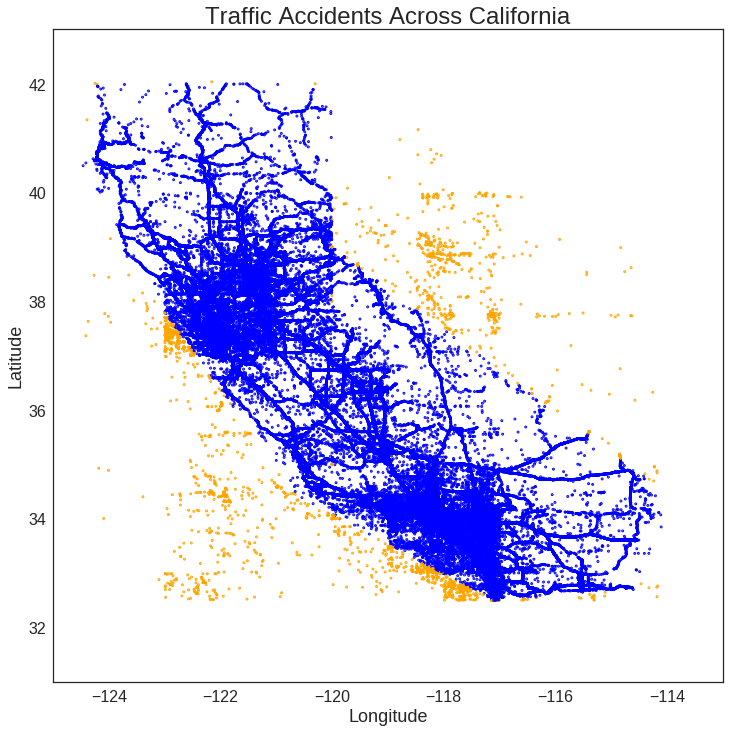

In [677]:
colors = ['blue' if in_bounds else 'orange' for in_bounds in df_switrs.In_Bounds]
    
draw_collision_map(df_switrs, colors);